# Recurrent Neural Network (RNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(0)

## Data

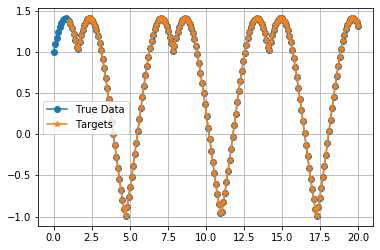

In [2]:
#Data
window = 10
n_data = 200 #Amount of Data
domain_x = 20 #Domain of Data
t = np.asarray(np.linspace(0, domain_x, n_data)) #Create X data
xt = np.asarray([np.sin(t[i])+abs(np.cos(t[i])) for i in range(n_data)]) #Create target data
x_w = np.asarray([xt[i:i+window] for i in range(len(xt)-window)]) #Embeding of window size
y = np.asarray(xt[window:]) #Targets
plt.plot(t,xt,label='True Data', marker='o')
plt.plot(t[window:],y,marker='*',label='Targets')
plt.legend(['True Data','Targets'])
plt.grid()
plt.show()

## MSE as Loss Function

In [3]:
def MSE(y_true,y_pred):
    return np.mean((y_true - y_pred) ** 2)

## Sigmoid as Activation Function

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Sigmoid Derivative for Backpropagation

In [5]:
def d_sig(x):
    return sigmoid(x)*(1-sigmoid(x))

## Long Short Term Memory Cell

In [6]:
#LSTM cell
class LSTM:
    
    def __init__(self, input_size, h_size):
        self.input_size = input_size
        self.h_size = h_size
        self.Wf = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Forget weights
        self.Wi = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Input weights
        self.Wo = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Output weights
        self.Wc = np.random.uniform(0, 1, (h_size, input_size + h_size)) #Cell Input weights
        self.bf = np.random.randn(h_size) #Forget bias
        self.bi = np.random.randn(h_size) #Input bias
        self.bo = np.random.randn(h_size) #Output bias
        self.bc = np.random.randn(h_size) #Cell Input bias
        self.c_state = np.random.uniform(-1, 1, (h_size,1)) #Cell state
        self.h_state = np.random.uniform(-1, 1, (h_size,1)) #Hidden state
        
        self.concat = np.zeros((input_size + h_size)) #Concatenated Values
        
        self.f = 0 #forget gate
        self.i = 0 #input gate
        self.o = 0 #output gate
        self.c_hat = 0 #candidate cell state
        
        self.Wf_g = np.zeros((h_size, input_size + h_size)) #Forget gradient
        self.Wi_g = np.zeros((h_size, input_size + h_size)) #Input Gradient
        self.Wo_g = np.zeros((h_size, input_size + h_size)) #Output Gradient
        self.Wc_g = np.zeros((h_size, input_size + h_size)) #Cell Gradient
        self.bf_g = np.zeros(h_size) #Forget bias gradient
        self.bi_g = np.zeros(h_size) #Input bias gradient
        self.bo_g = np.zeros(h_size) #Output bias gradient
        self.bc_g = np.zeros(h_size) #Cell bias Gradient
        self.c_state_g = np.zeros(h_size) #Cell State Gradient
        self.h_state_g = np.zeros(h_size) #Hidden State Gradient
        
    def forward(self, x, h_prev, c_prev):
        self.concat = np.hstack((h_prev, x)) #Concatenated hidden state and input
        self.f = sigmoid(np.dot(self.Wf, self.concat) + self.bf) #Forget cell
        self.i = sigmoid(np.dot(self.Wi, self.concat) + self.bi) #Input cell
        self.o = sigmoid(np.dot(self.Wo, self.concat) + self.bo) #Output cell
        self.c_hat = np.tanh(np.dot(self.Wc, self.concat) + self.bc) #Cell state

        self.c_state = self.f * c_prev + self.i * self.c_hat #New Cell State
        self.h_state = self.o * np.tanh(self.c_state) #New Hidden State

        return self.h_state, self.c_state
    
    def backward(self, x, d_h_state, d_c_state):
        self.h_state_g = d_h_state 
        d_o = d_h_state * np.tanh(self.c_state) * d_sig(np.dot(self.Wo, self.concat) + self.bo)
        d_c = (d_h_state * self.o * (1 - np.tanh(self.c_state)**2)) + d_c_state
        d_i = d_c * self.c_hat * d_sig(np.dot(self.Wi, self.concat) + self.bi)
        d_f = d_c * self.c_state * d_sig(np.dot(self.Wf, self.concat) + self.bf)
        d_c_hat = d_c * self.i * (1 - self.c_hat**2)
        
        self.Wf_g += np.outer(d_f, self.concat)
        self.Wi_g += np.outer(d_i, self.concat)
        self.Wc_g += np.outer(d_c_hat, self.concat)
        self.Wo_g += np.outer(d_o, self.concat)
        
        self.bf_g += d_f
        self.bi_g += d_i
        self.bc_g += d_c_hat
        self.bo_g += d_o
        
        dconcat = np.dot(self.Wf.T, d_f) + np.dot(self.Wi.T, d_i) + np.dot(self.Wc.T, d_c_hat) + np.dot(self.Wo.T, d_o)
        
        dx = dconcat[:self.input_size] 
        dh_prev = dconcat[self.input_size:]

        return dx, dh_prev, d_c * self.f
    
    def update(self, lr=0.0001):
        self.Wf -= lr * self.Wf_g
        self.Wi -= lr * self.Wi_g
        self.Wc -= lr * self.Wc_g
        self.Wo -= lr * self.Wo_g
        
        self.bf -= lr * self.bf_g
        self.bi -= lr * self.bi_g
        self.bc -= lr * self.bc_g
        self.bo -= lr * self.bo_g
        
        # Reset gradients after updating
        self.Wf_g.fill(0)
        self.Wi_g.fill(0)
        self.Wc_g.fill(0)
        self.Wo_g.fill(0)
        
        self.bf_g.fill(0)
        self.bi_g.fill(0)
        self.bc_g.fill(0)
        self.bo_g.fill(0)


## Recurrent Neural Network

In [7]:
class RNN:
    def __init__(self, input_size, h_size, out_size, lr=0.001, x_dim=1):
        self.input_size = input_size
        self.h_size = h_size
        self.out_size = out_size

        self.LSTM_Cells = [] #List of LSTM cells
        for j in range(self.input_size): 
            self.LSTM_Cells.append(LSTM(x_dim, self.h_size)) #Create an LSTM cell for each input

        self.H = [np.zeros(h_size)]  #List of hidden states for each LSTM cell
        self.C = [np.zeros(h_size)]  #List of cell states for each LSTM cell

        self.Wy = np.random.rand(out_size, h_size) #Output weights
        self.by = np.zeros(out_size) #Output bias

        self.dWy = np.zeros((out_size, h_size)) #Output weight derivative
        self.dby = np.zeros(out_size) #Output bias derivative

        self.lr = lr #Learning Rate

        self.Losses = [] #List of losses through the epochs
 
    def forward(self, x):
        self.H = [np.zeros(self.h_size)] #List of hidden values
        self.C = [np.zeros(self.h_size)] #List of hidden cell states
        for t in range(self.input_size):
            h, c = self.LSTM_Cells[t].forward(x[t], self.H[-1], self.C[-1]) #Iterate through all LSTM Cells
            self.H.append(h)
            self.C.append(c)
        y = self.Wy.dot(h) + self.by #output
        return y

    def backward(self, x, dy):
        self.dWy = dy * self.H[-1].reshape(-1, 1).T
        self.dby = dy

        dh = self.Wy.T.dot(dy)
        dc = np.zeros_like(self.C[-1])
        for t in reversed(range(self.input_size)):
            dx, dh, dc = self.LSTM_Cells[t].backward(x[t], dh, dc) #Iterate backward through all LSTM Cells

    def train(self, x, yt, epochs=1000, lr_dec=False):
        for epoch in range(epochs): #Iterate through epochs
            epoch_loss = 0 #Acumulative loss
            for i in range(len(x)): #Iterate through all data embedings
                out = self.forward(x[i]) #Forward pass
                loss = MSE(out, yt[i]) #Loss calculation
                epoch_loss += loss #Add acumulative loss

                dy = out - yt[i] #Loss derivative
                self.backward(x[i], dy) #backward pass/ backpropagation

                self.Wy -= self.lr * self.dWy #Output weights update
                self.by -= self.lr * self.dby #Bias update

                for l in self.LSTM_Cells: #Iterate through LSTM Cells for update
                    l.update(self.lr)
                    
            if lr_dec == True: #Learning rate descent       
                self.lr *= 0.999

            self.Losses.append(epoch_loss / len(x))
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(x)}',end='\r')

## RNN training

In [10]:
R = RNN(window,10,1)
R.train(x_w,y,1000)

In [14]:
R.train(x_w,y,1000)

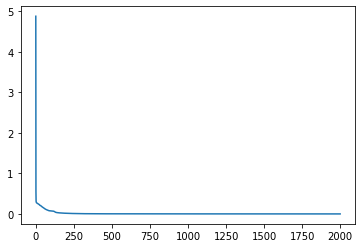

In [15]:
plt.plot(R.Losses)

## Predictions

In [12]:
def Predict(R,N,xt,emb,plot=True):
    #Prediction
    N = N - emb
    window = R.input_size
    y_pred = np.zeros((N + emb))  # +window to include the first window predictions

    # Generate the first window predictions
    y_pred[0] = R.forward(xt[-emb:])
    for i in range(1,emb):
        y_pred[i] = R.forward(np.concatenate((xt[-emb + i:], y_pred[:i])))

    # Generate the remaining N predictions
    for i in range(emb, N + emb):
        y_pred[i] = R.forward(y_pred[i - emb:i])

    # Concatenate initial data with predictions
    Y = np.concatenate((xt, y_pred))
    T = list(range(Y.shape[0]))
    
    if plot == True:
        plt.plot(T[:n_data],Y[:n_data],marker='o',label='Training')
        plt.plot(T[n_data:],Y[n_data:],marker='*',label='Predicted')
        plt.legend(['Training','Predicted'])
        plt.grid()
        plt.show()
    
    return y_pred

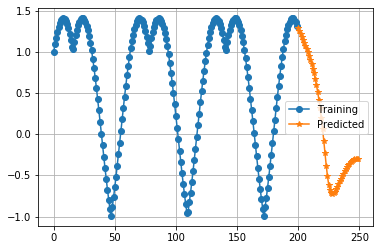

In [26]:
y_pred = Predict(R,50,xt,window,True)

## Optimize Initialization of Network

In [20]:
def Op_Init_Net(NN,x_w,h_size,y):
    in_size = 1 if len(y.shape) == 1 else y.shape[1]
    Nets = [RNN(x_w.shape[1],h_size,in_size) for i in range(NN)]
    L = np.zeros((NN))
    for n in range(len(Nets)):
        l = 0
        for j in range(len(x_w)):
            l += MSE(Nets[n].forward(x_w[j]),y[j])
        L[n] = l
    return Nets[np.argmin(L)]

In [21]:
def Op_Init_Net(NN,x_w,h_size,y):
    in_size = 1 if len(y.shape) == 1 else y.shape[1]
    Best = None
    BL = 999999
    for n in range(NN):
        Net = RNN(x_w.shape[1],h_size,in_size)
        l = 0
        for j in range(len(x_w)):
            l += MSE(Net.forward(x_w[j]),y[j])
        if l<BL:
            Best = Net
            BL = l
    return Best

### Single RNN

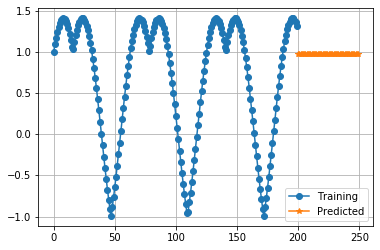

In [32]:
R1 = RNN(window,10,1)
R1.train(x_w,y,50)
y_pred = Predict(R1,50,xt,window,True)

### 100 RNN

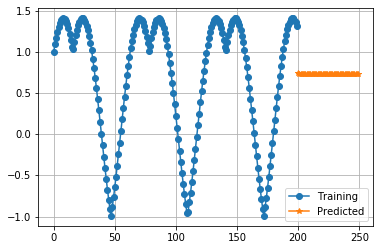

In [33]:
R2 = Op_Init_Net(100,x_w,10,y)
R2.train(x_w,y,50)
y_pred = Predict(R2,50,xt,window,True)

### 10000 RNN

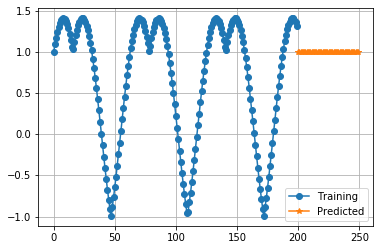

In [35]:
R3 = Op_Init_Net(1000,x_w,10,y)
R3.train(x_w,y,50)
y_pred = Predict(R3,50,xt,window,True)